In [ ]:
!pip install burr[start] langchain_core langchain_community pydantic
# we only need these to show case the automatic serialization and deserialization that Burr has.

# Create a custom serializer and deserializer

In this notebook you'll find an explanation of how to create a custom serializer and deserializer for state that Burr captures.

Specifically there are four things to grok:

1. Burr has some default type based serializers and deserializers that it uses to serialize and deserialize state. 
2. You can register type based serializers and deserializers with Burr.
3. You can register state field level serializers and deserializers with Burr.
4. Burr assumes that the end result of the serialization and deserialization is a dictionary that can be JSON serialized and deserialized.

In [1]:
# import what we need
import pprint
import uuid
import pydantic
from langchain_core import documents

from burr import core
from burr.core import State, action, expr, state, serde
from burr.tracking import client as tracking_client


# Building a custom serializer and deserializer for a class type
Say we have have a custom class that we want to serialize and deserialize using custom serde.

With Burr we just register a type based serializer and deserializer for the class.

1. We first define the class we want to serialize and deserialize.
2. Then we define a serializer and deserializer for the class -- using the `@serde.serialize.register` and `@serde.deserializer.register` decorators to register the serializer and deserializer with Burr for that class.

Note the function signatures, return types, and the decorators used.

In [2]:
class CustomClass(object):
    """Custom class we'll use to test custom serde"""

    def __init__(self, value):
        self.value = value

    def __eq__(self, other):
        # required for asserts etc to work
        return self.value == other.value


# create custom serializer for the custom class & register it
@serde.serialize.register(CustomClass)
def serialize_customclass(value: CustomClass, **kwargs) -> dict:
    """Serializes the custom class however we want

    :param value: the value to serialize.
    :param kwargs:
    :return: dictionary of serde.KEY and value
    """
    return {
        serde.KEY: "CustomClass",  # this has to map to the value regisered for the deserializer below
        "value": f"[value=={value.value}]",  # serialize the value however we want
    }


# create custom deserializer for the custom class & register it
@serde.deserializer.register("CustomClass")
def deserialize_customclass(value: dict, **kwargs) -> CustomClass:
    """Deserializes the value using whatever meands we want

    :param value: the value to deserialize from.
    :param kwargs:
    :return: CustomClass
    """
    # deserialize the value however we want
    return CustomClass(value=value["value"].split("==")[1][0:-1])

# Field level serialization and deserialization
If we have to do something different from the usual type based serialization and deserialization, we can register field level serializers and deserializers.

For some odd case you might have a field that needs to be serialized and deserialized differently but it's the same type as other fields so you can't just register a type based serializer and deserializer.

This follows a similar approach to the above, except that we register the functions via `state.register_field_serde()`.

In [3]:
# create serializer
def my_field_serializer(value: documents.Document, **kwargs) -> dict:
    """Say we want to serialize langchain documents differently"""
    serde_value = f"serialized::{value.page_content}"
    return {"value": serde_value}

# create deserializer
def my_field_deserializer(value: dict, **kwargs) -> documents.Document:
    """Say we want to deserialize langchain documents differently"""
    serde_value = value["value"]
    return documents.Document(page_content=serde_value.replace("serialized::", ""))

# register the global field level serializer and deserializer
state.register_field_serde("custom_field", my_field_serializer, my_field_deserializer)


# Define the actions
Let's now defin the application by starting with actions.

This example shows that pydantic, and langchain documents are automatically serialized and deserialized by Burr.

In [4]:
@action(reads=[], writes=["dict"])
def basic_action(state: State, user_input: str) -> tuple[dict, State]:
    """Action putting a bunch of things in state."""
    v = {"foo": 1, "bar": CustomClass("example value"), "bool": True, "None": None, "input": user_input}
    return {"dict": v}, state.update(dict=v)

In [5]:
class PydanticField(pydantic.BaseModel):
    """burr handles serializing custom pydantic fields"""
    f1: int = 0
    f2: bool = False


@action(reads=["dict"], writes=["pydantic_field"])
def pydantic_action(state: State) -> tuple[dict, State]:
    """Action adding a pydantic field to state."""
    v = PydanticField(f1=state["dict"]["foo"], f2=state["dict"]["bool"])
    return {"pydantic_field": v}, state.update(pydantic_field=v)


In [6]:
@action(reads=["pydantic_field"], writes=["lc_doc"])
def langchain_action(state: State) -> tuple[dict, State]:
    """Action adding a langchain document to state."""
    v = documents.Document(
        page_content=f"foo: {state['pydantic_field'].f1}, bar: {state['pydantic_field'].f2}"
    )
    return {"lc_doc": v}, state.update(lc_doc=v)

In [7]:
@action(reads=["lc_doc"], writes=[])
def terminal_action(state: State) -> tuple[dict, State]:
    """terminal action"""
    return {"output": state["lc_doc"].page_content}, state


# Build the application

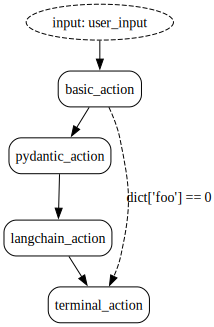

In [14]:
tracker = tracking_client.LocalTrackingClient("serde-example")
app = (
    core.ApplicationBuilder()
    .with_actions(basic_action, pydantic_action, langchain_action, terminal_action)
    .with_transitions(
        ("basic_action", "terminal_action", expr("dict['foo'] == 0")),
        ("basic_action", "pydantic_action"),
        ("pydantic_action", "langchain_action"),
        ("langchain_action", "terminal_action"),
    )
    .with_identifiers(partition_key="user-1234", app_id=str(uuid.uuid4()))
    .initialize_from(
        tracker,
        resume_at_next_action=True,
        default_state={
            # this will use the custom field level serializer and deserializer
            "custom_field": documents.Document(
                page_content="this is a custom field to serialize"
            )
        },
        default_entrypoint="basic_action",
    )
    .with_tracker(tracker)
    .build()
)
app.visualize(include_conditions=True)

# Run the application
Let's run it and then check the state to see how the custom serialization and deserialization worked.

In [9]:
action, result, state = app.run(halt_after=["terminal_action"], inputs={"user_input": "hello world"})

In [10]:
# serialize
serialized_state = state.serialize()
pprint.pprint(serialized_state)

{'__PRIOR_STEP': 'terminal_action',
 '__SEQUENCE_ID': 3,
 'custom_field': {'value': 'serialized::this is a custom field to serialize'},
 'dict': {'None': None,
          'bar': {'__burr_serde__': 'CustomClass',
                  'value': '[value==example value]'},
          'bool': True,
          'foo': 1,
          'input': 'hello world'},
 'lc_doc': {'__burr_serde__': 'lc_document',
            'id': ['langchain', 'schema', 'document', 'Document'],
            'kwargs': {'page_content': 'foo: 1, bar: True', 'type': 'Document'},
            'lc': 1,
            'type': 'constructor'},
 'pydantic_field': {'__burr_serde__': 'pydantic',
                    '__pydantic_class': '__main__.PydanticField',
                    'f1': 1,
                    'f2': True}}


In [11]:
# deserialize
deserialized_state = State.deserialize(serialized_state)
# assert that the state is the same after serialization and deserialization
assert state.get_all() == deserialized_state.get_all()

/Users/stefankrawczyk/.pyenv/versions/3.10.4/envs/burr-py310/lib/python3.10/site-packages/langchain_core/_api/beta_decorator.py:87: LangChainBetaWarning: The function `load` is in beta. It is actively being worked on, so the API may change.
  warn_beta(


# Go view the trace in the tracking client
You'll see that after each action the state is correctly serialized as we intended.

[http://localhost:7241](http://localhost:7241)